In [1]:
import pandas as pd
from catboost import CatBoostRegressor

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/Oscar19922017/SeriesTiempo2023/main/Servicios_Dia_Autos.csv")

In [3]:
df=df[["Date","ANTIOQUIA_CHOCO"]]
df["Date"]=df["Date"].apply(pd.to_datetime)
df.rename(columns={"ANTIOQUIA_CHOCO":"y"},inplace=True)
df=df.set_index("Date")
df["Fecha"]=df.index

In [4]:
df.Fecha.min(),df.Fecha.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2022-02-28 00:00:00'))

In [5]:
df["Fecha"][-1]

Timestamp('2022-02-28 00:00:00')

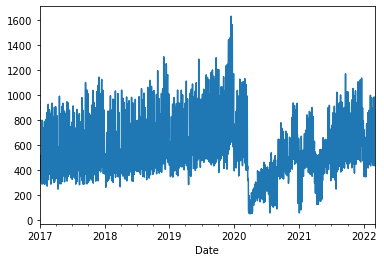

In [6]:
df.y.plot();

In [7]:
df['mes_del_anio'] = df['Fecha'].dt.strftime('%B')
df['dia_de_la_semana'] = df['Fecha'].dt.strftime('%A')
df["dia_mes"]=df['Fecha'].dt.strftime('%d')

In [8]:
rango_fechas = pd.date_range(start=df["Fecha"][-1], periods=30, freq='D')
Pronostico=pd.DataFrame({"Date":rango_fechas})
Pronostico=Pronostico.set_index("Date")
Pronostico['Fecha']=Pronostico.index
Pronostico['mes_del_anio'] = Pronostico['Fecha'].dt.strftime('%B')
Pronostico['dia_de_la_semana'] = Pronostico['Fecha'].dt.strftime('%A')
Pronostico["dia_mes"]=Pronostico['Fecha'].dt.strftime('%d')

In [9]:
df["tipo"]="historia"

In [10]:
Pronostico["tipo"]="nuevo"

In [11]:
Unirlos= pd.concat([df, Pronostico], axis=0)
Unirlos

,y,Fecha,mes_del_anio,dia_de_la_semana,dia_mes,tipo
Date,,,,,,
2017-01-01,305.0,2017-01-01,January,Sunday,01,historia
2017-01-02,452.0,2017-01-02,January,Monday,02,historia
2017-01-03,406.0,2017-01-03,January,Tuesday,03,historia
2017-01-04,335.0,2017-01-04,January,Wednesday,04,historia
2017-01-05,360.0,2017-01-05,January,Thursday,05,historia
...,...,...,...,...,...,...
2022-03-25,NaN,2022-03-25,March,Friday,25,nuevo
2022-03-26,NaN,2022-03-26,March,Saturday,26,nuevo
2022-03-27,NaN,2022-03-27,March,Sunday,27,nuevo


In [12]:
dummies=pd.get_dummies(Unirlos[["mes_del_anio","dia_de_la_semana","dia_mes"]],drop_first=True)
df2 = pd.concat([Unirlos[["tipo","y"]], dummies], axis=1)
df2.head(2)

,tipo,y,mes_del_anio_August,mes_del_anio_December,mes_del_anio_February,mes_del_anio_January,mes_del_anio_July,mes_del_anio_June,mes_del_anio_March,mes_del_anio_May,...,dia_mes_22,dia_mes_23,dia_mes_24,dia_mes_25,dia_mes_26,dia_mes_27,dia_mes_28,dia_mes_29,dia_mes_30,dia_mes_31
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,historia,305.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,historia,452.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
x=df2[df2["tipo"]=="historia"].drop(columns=["y","tipo"])
y=df2[df2["tipo"]=="historia"].y

In [14]:
catboost_model = CatBoostRegressor(
 depth =2,
  l2_leaf_reg = 13,
  loss_function =  "RMSE" ,
  border_count = 254,
  verbose = False,
  random_strength = 0.0,
  task_type =  "CPU" ,
  n_estimators = 164,
  random_state = 123,
  eta = 0.25532707800586046
)
catboost_model.fit(x, y, verbose=100)  # verbose muestra el progreso durante el entrenamiento

0:	learn: 212.3205536	total: 52.4ms	remaining: 8.55s
100:	learn: 158.6728015	total: 77.7ms	remaining: 48.4ms
163:	learn: 155.4477060	total: 89.7ms	remaining: 0us


## **Pronostico**

In [20]:
#x_nueva.head()

In [16]:
x_nueva=df2[df2["tipo"]=="nuevo"].drop(columns=["y","tipo"])

In [17]:
y_pred = catboost_model.predict(x_nueva)

In [21]:
y_pred

array([506.7804611 , 458.82520313, 437.64553247, 456.30817901,
       605.15522436, 779.11235555, 355.28334336, 459.00984836,
       450.38530084, 430.99908696, 451.11164148, 598.96988652,
       789.77725511, 363.78649166, 450.44032945, 466.08090852,
       437.64553247, 456.30817901, 621.65151539, 786.68498007,
       357.69869012, 452.10545551, 458.82520313, 437.64553247,
       456.30817901, 591.29887163, 785.11372503, 357.69869012,
       462.20866647, 458.82520313])

In [23]:
df2["y"][df2["tipo"]=="nuevo"]=y_pred

/var/folders/vt/2t0v0kt92gj1_bvmhn234x6ng8b83c/T/ipykernel_67646/2139051839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["y"][df2["tipo"]=="nuevo"]=y_pred


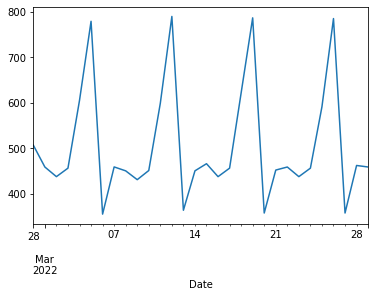

In [37]:
steps=30
df2[-steps:].y.plot();

In [47]:
df2[["y","tipo"]].to_excel("Pronostico Marzo.xlsx")